##### CSCI 303
# Introduction to Data Science
<p/>
### 16 - Classification via Support Vector Machines

![maximum margin classifier (SVM)](svm.png) 

## This Lecture
---
- Classification via Support Vector Machine

## Setup
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

from scipy.stats import norm
from pandas import Series, DataFrame
from matplotlib.colors import ListedColormap

plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Example Problem
---
This synthetic problem creates two clusters of points which are normally distributed in two dimensions.  We're going to start with data which is linearly separable in order to explain SVM better.

In [2]:
# ensure repeatability of this notebook 
# (comment out for new results each run)
np.random.seed(12345)

# Get some normally distributed samples
def sample_cluster(n, x, y, sigma):
    x = np.random.randn(n) * sigma + x;
    y = np.random.randn(n) * sigma + y;
    return np.array([x, y]).T

c1 = sample_cluster(25, 1, 0, 0.3)
c2 = sample_cluster(25, 0, 1, 0.2)
d1 = DataFrame(c1, columns=['x','y'])
d2 = DataFrame(c2, columns=['x','y'])
d1['class'] = 'a'
d2['class'] = 'b'
data = d1.append(d2)
data.index = pd.RangeIndex(50)

## Novice programmer tip:

In the cell of code above, what might you do if you don't  
understand why the last line was used, or what it does?

How might you find out the answer?
1. Look at the documentation for [pandas.RangeIndex](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.RangeIndex.html) (Google for it is usually fasted way to find the webpage).
2. Write some additinal code to investigate. See cell below.

In [3]:
## Novice programmer tip

# Let's figure out what pd.RangeIndex(50) did, and why we needed it...

# First, let's see what the variable data was and held, prior to the RangeIndex call.
data = d1.append(d2)
data

,x,y,class
0,0.938588,0.037236,a
1,1.143683,0.090784,a
2,0.844168,0.157132,a
3,0.833281,0.000282,a
4,1.589734,0.403143,a
5,1.418022,-0.214063,a
6,1.027872,-0.249346,a
7,1.084524,-0.711069,a
8,1.230707,-0.558228,a
9,1.373930,-0.258227,a


In [4]:
## Novice programmer tip (contintued)

# Ah. We see that the data.append() statement appended d1 and d2, as requested,
# and also kept the index names for d1 and d2, such that the 0 to 24 labels of
# both are now used twice. What happens if we try to extract rows with a specific
# index name (number, in this case)? Let's use the .loc() method to do so.

data.loc[5]

,x,y,class
5,1.418022,-0.214063,a
5,-0.183852,1.010263,b


In [5]:
## Novice programmer tip (contintued)

# Yep, it gave us the two rows that use 5 as their index.
# If we want to be able to uniquely index each row, we need to give
# the data DataFrame new indices. Seems likely that that's what
# RangeIndex() does. Let's confirm this...
data.index = pd.RangeIndex(50)
data

,x,y,class
0,0.938588,0.037236,a
1,1.143683,0.090784,a
2,0.844168,0.157132,a
3,0.833281,0.000282,a
4,1.589734,0.403143,a
5,1.418022,-0.214063,a
6,1.027872,-0.249346,a
7,1.084524,-0.711069,a
8,1.230707,-0.558228,a
9,1.373930,-0.258227,a


In [6]:
## Novice programmer tip (contintued)

# Yep. The RangeIndex(50) command created new indices for the DataFrame,
# from 0 to 49 (50-1).

# So now we understand!

## Back to the lecture...

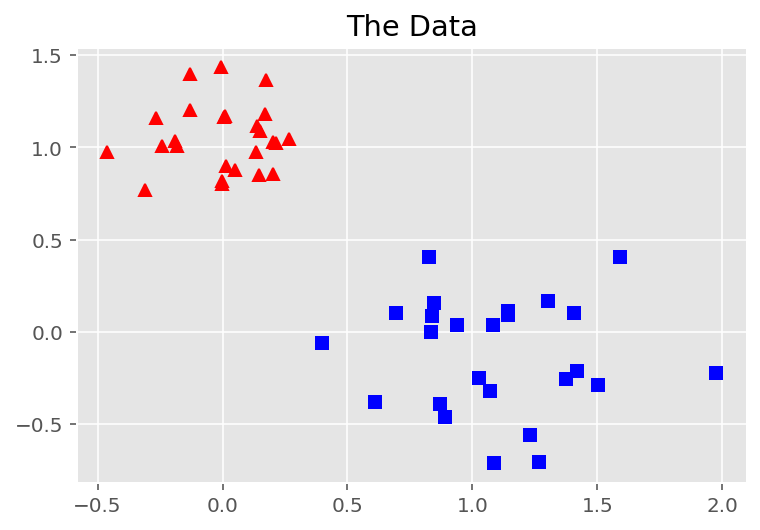

In [7]:
plt.plot(c1[:,0], c1[:,1], 'bs', label='a')
plt.plot(c2[:,0], c2[:,1], 'r^', label='b')
plt.title('The Data')
plt.show()

Note that this data is well separated, and there are many possible linear separators.

Which one is best?

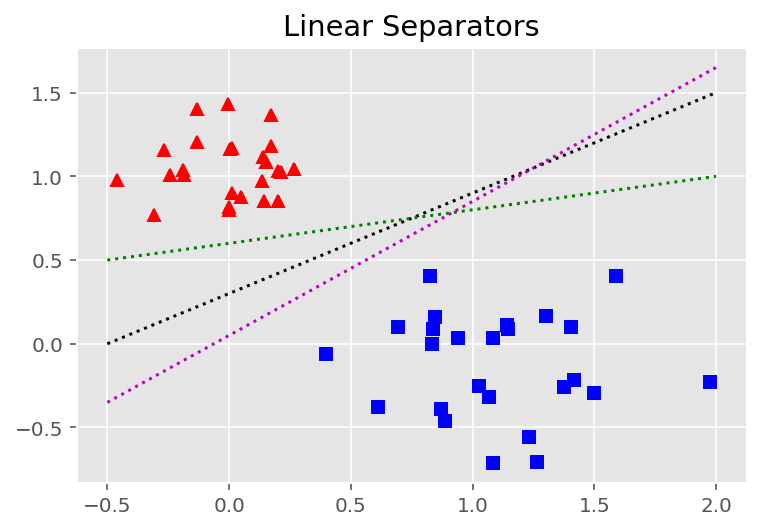

In [8]:
plt.plot(c1[:,0], c1[:,1], 'bs', label='a')
plt.plot(c2[:,0], c2[:,1], 'r^', label='b')
plt.plot([-0.5, 2.0], [0, 1.5], 'k:')
plt.plot([-0.5, 2.0], [0.5, 1.0], 'g:')
plt.plot([-0.5, 2.0], [-0.35, 1.65], 'm:')
plt.title('Linear Separators')
plt.show()

## Maximum Margin Classifier
---
One answer to the question is, where can we draw the line such that the nearest exemplar(s) in each class are equidistant from the line, and where the distance is as maximal as possible?

It turns out this produces a neat little convex quadratic program, which we can feed to any QP solver.

Downside: it can be expensive with lots of data!

(Math omitted - beyond the scope of this course)

To show what the maximum margin classifier looks like on our data, we're going to create a linear SVM classifier, and fit it using all of the data.

In [9]:
from sklearn import svm
model = svm.SVC(kernel='linear', C=10)
model.fit(data[['x','y']], data['class'])

SVC(C=10, kernel='linear')

The `plot_predicted` function below is what we've been using to visualize our data points (correctly and incorrectly classified), together with lines that show us the decision boundary and the support vectors.

In [10]:
def plot_predicted(model, data):
    predicted = model.predict(data[['x','y']])
    correct = data[data['class'] == predicted]
    correcta = correct[correct['class'] == 'a']
    correctb = correct[correct['class'] == 'b']
    incorrect = data[data['class'] != predicted]
    incorrecta = incorrect[incorrect['class'] == 'b']
    incorrectb = incorrect[incorrect['class'] == 'a']
    
    plt.plot(correcta['x'], correcta['y'], 'bs', label='a')
    plt.plot(correctb['x'], correctb['y'], 'r^', label='b')
    plt.plot(incorrecta['x'], incorrecta['y'], 'bs', markerfacecolor='w', label='a (misclassified)')
    plt.plot(incorrectb['x'], incorrectb['y'], 'r^', markerfacecolor='w', label='b (misclassified)')
    plt.legend(ncol=2)

The rather complicated `plot_linear_separator` function below extracts the relevant data from the model to plot the linear decision function and the parallel "maximum margin" that was found.

In [11]:
def plot_linear_separator(model, data, ax=None):
    # This code modified from Scikit-learn documentation on SVM
    if ax is None:
        plt.figure(figsize=(8,6))
    else:
        plt.sca(ax)
    
    # get the separating hyperplane as ax + y + c = 0
    w = model.coef_[0]
    a = w[0] / w[1]
    c = (model.intercept_[0]) / w[1]
    xx = np.linspace(data['x'].min(), data['x'].max())
    yy = -a * xx - c

    # find the support vectors that define the maximal separation
    # there ought to be a better way...
    spos = 0
    sneg = 0
    sposdist = 0
    snegdist = 0
    for s in model.support_vectors_:
        # find the orthogonal point
        ox = (s[0] - a * s[1] - a * c) / (a * a + 1)
        oy = (a * (a * s[1] - s[0]) - c) / (a * a + 1) 
        
        # find the squared distance
        d = (s[0] - ox)**2 + (s[1] - oy)**2
        
        if s[1] > oy and d > sposdist:
            spos = s
            sposdist = d
        if s[1] < oy and d > snegdist:
            sneg = s
            snegdist = d
    
    
    # plot the parallels to the separating hyperplane that pass through the
    # support vectors
    yy_pos = -a * xx + (spos[1] + a * spos[0])
    yy_neg = -a * xx + (sneg[1] + a * sneg[0])
    
    # plot the separator and the maximum margin lines
    plt.plot(xx, yy, 'k-', label='Boundary')
    plt.plot(xx, yy_pos, 'k:')
    plt.plot(xx, yy_neg, 'k:')

    plt.plot(model.support_vectors_[:, 0], model.support_vectors_[:, 1], 'ko', markerfacecolor='#00000044', markersize=10, label='Support')

    # plot the points
    plot_predicted(model, data)
    plt.legend(ncol=3)

And finally, here's the plot, showing our data:

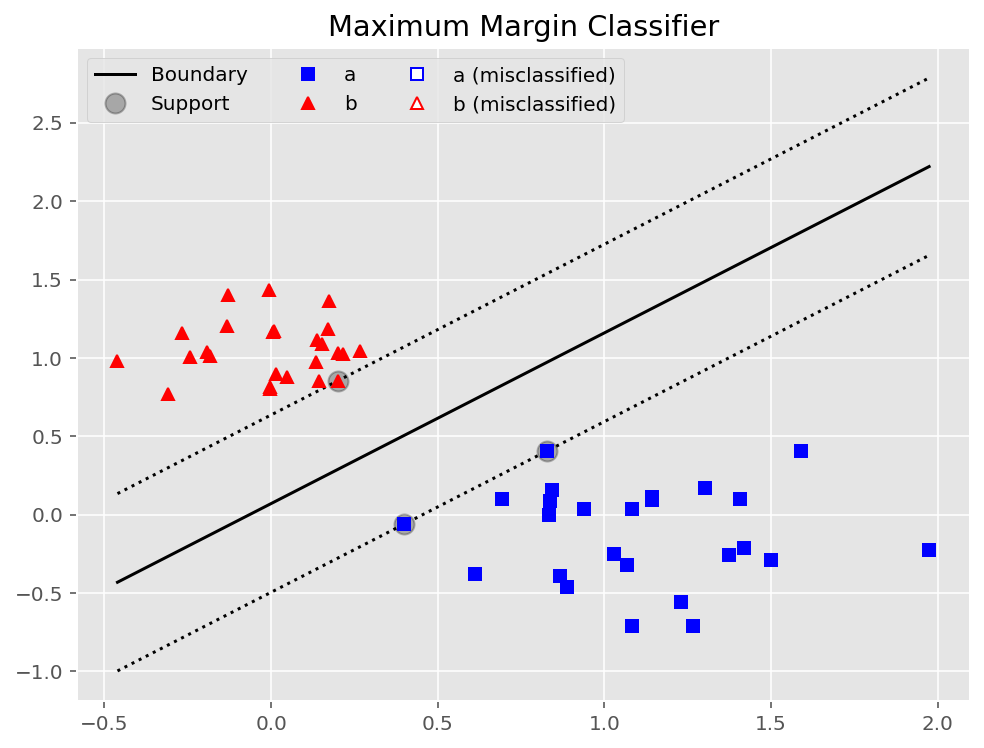

In [13]:
plot_linear_separator(model, data)
plt.title('Maximum Margin Classifier')
plt.show()

The solid line in the plot above is the decision boundary.

The dotted lines show the margin area between the classifier and the nearest points in the two clusters.

Note that the dotted lines pass through points in the clusters; these points are called the *support vectors* of the classifier.


## Non-Separable Data
---
So what happens when the data is not linearly separable?

Our QP will break, because there is no feasible solution.

So, the clever fix is to relax the QP to allow points to be *misclassified*; but to get the best classifier possible, a penalty is attached to each misclassified point.

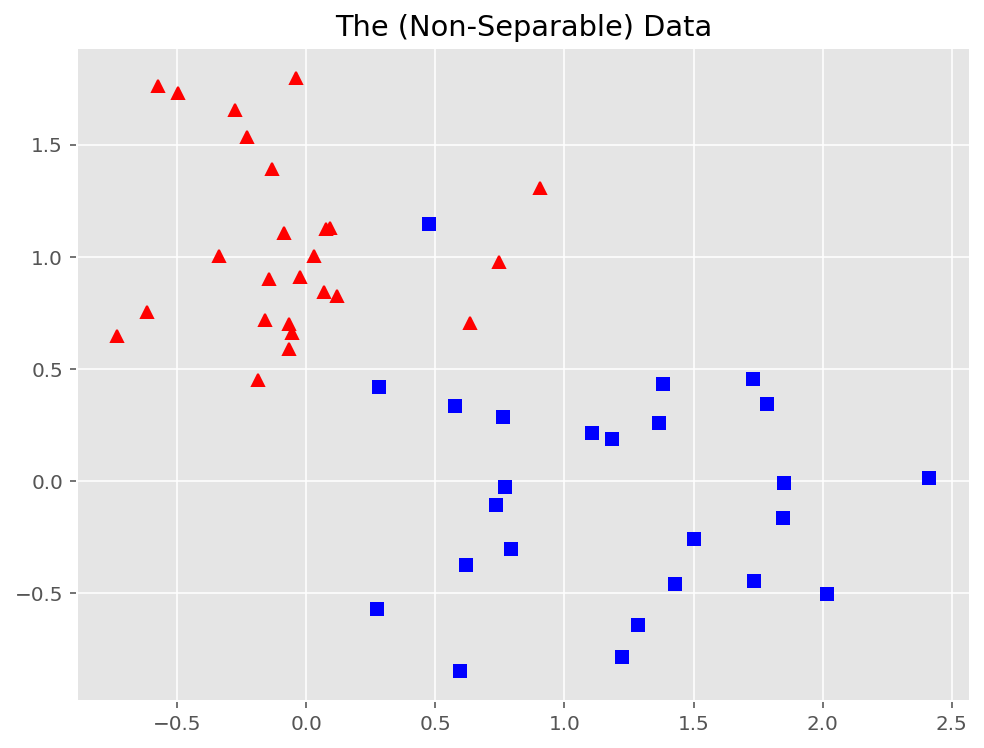

In [14]:
c1 = sample_cluster(25, 1, 0, 0.5)
c2 = sample_cluster(25, 0, 1, 0.4)
d1 = DataFrame(c1, columns=['x','y'])
d2 = DataFrame(c2, columns=['x','y'])
d1['class'] = 'a'
d2['class'] = 'b'
data = d1.append(d2)
data.index = pd.RangeIndex(50)

plt.figure(figsize=(8,6))
plt.plot(c1[:,0], c1[:,1], 'bs', label='a')
plt.plot(c2[:,0], c2[:,1], 'r^', label='b')
plt.title('The (Non-Separable) Data')
plt.show()

Let's see what the support vector classifier does with this data:

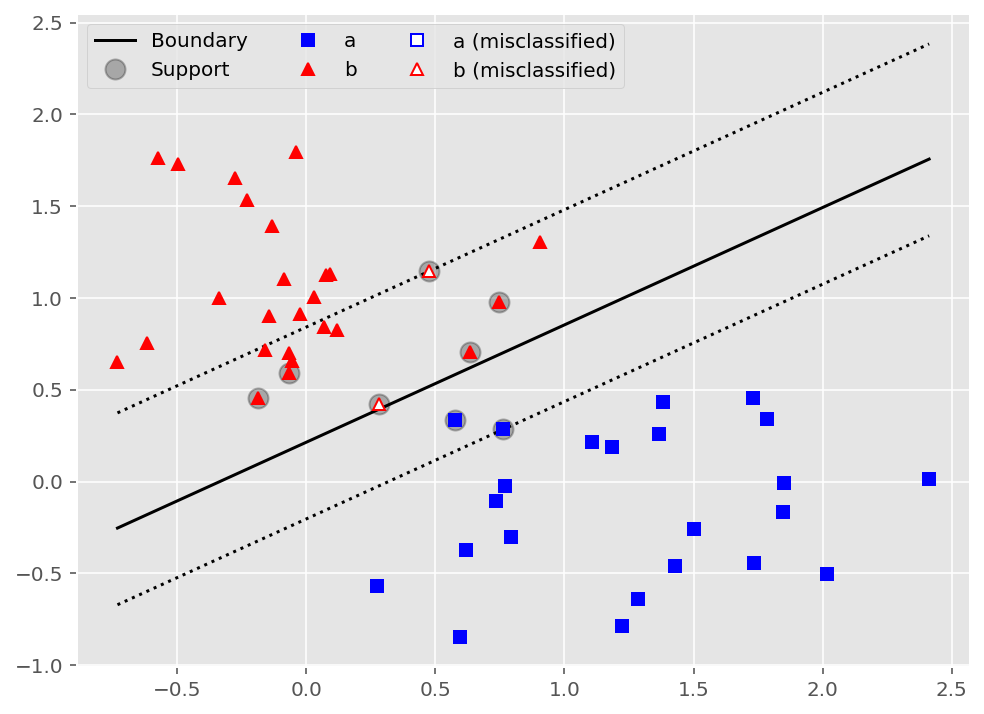

In [16]:
model = svm.SVC(kernel='linear', C=10) # call the support vector classifier function on the model
model.fit(data[['x','y']], data['class'])
plot_linear_separator(model, data)

## Effect of C parameter
---
The strength of the penalty term for the QP is controlled by a new parameter: C.

A larger C means a stronger penalty, i.e., gives the QP incentive to reduce misclassifications.

Above we used C = 10.

Let's see the effects of different choices for C:

C = 1

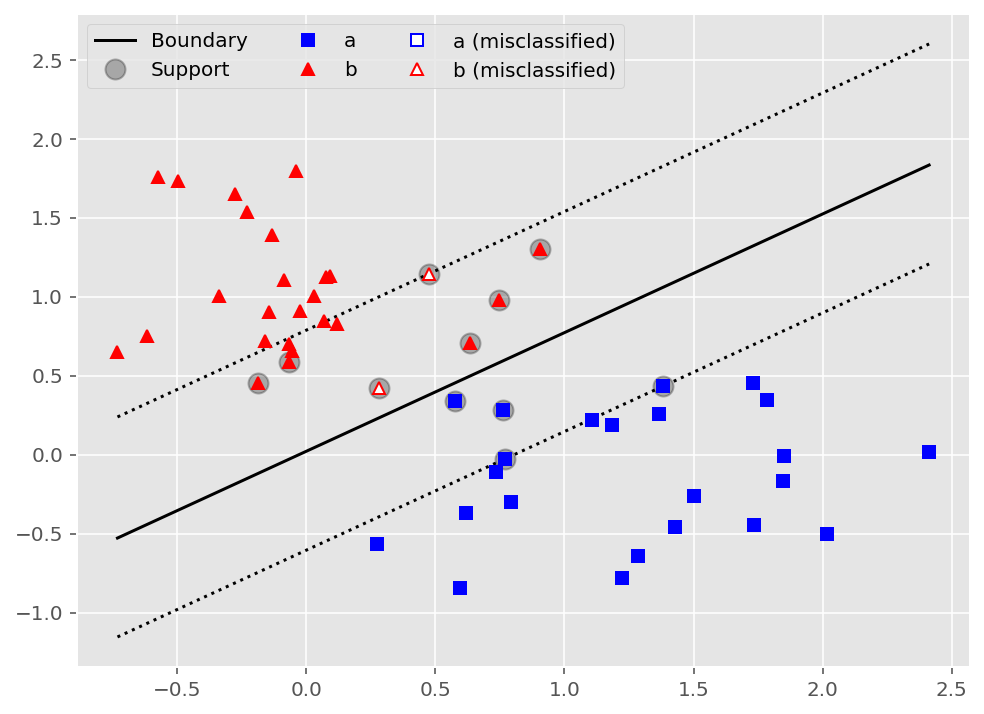

In [17]:
model = svm.SVC(kernel='linear', C=1) 
model.fit(data[['x','y']], data['class'])
plot_linear_separator(model, data)

C = 0.1

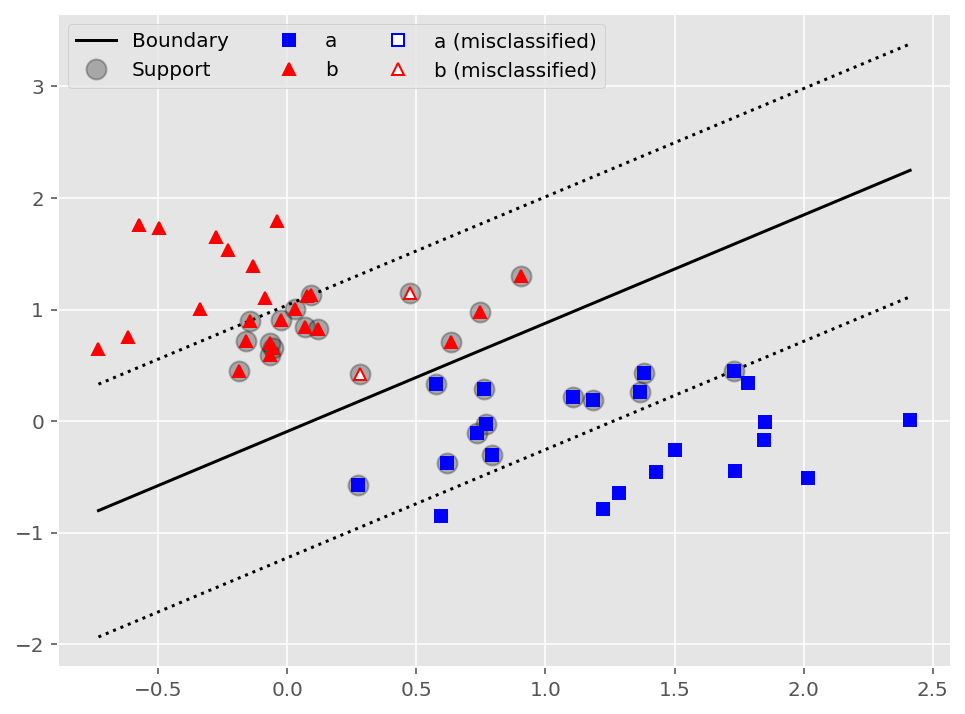

In [18]:
model = svm.SVC(kernel='linear', C=0.1) # will have the largest margin hyperplane
model.fit(data[['x','y']], data['class'])
plot_linear_separator(model, data)

C = 100

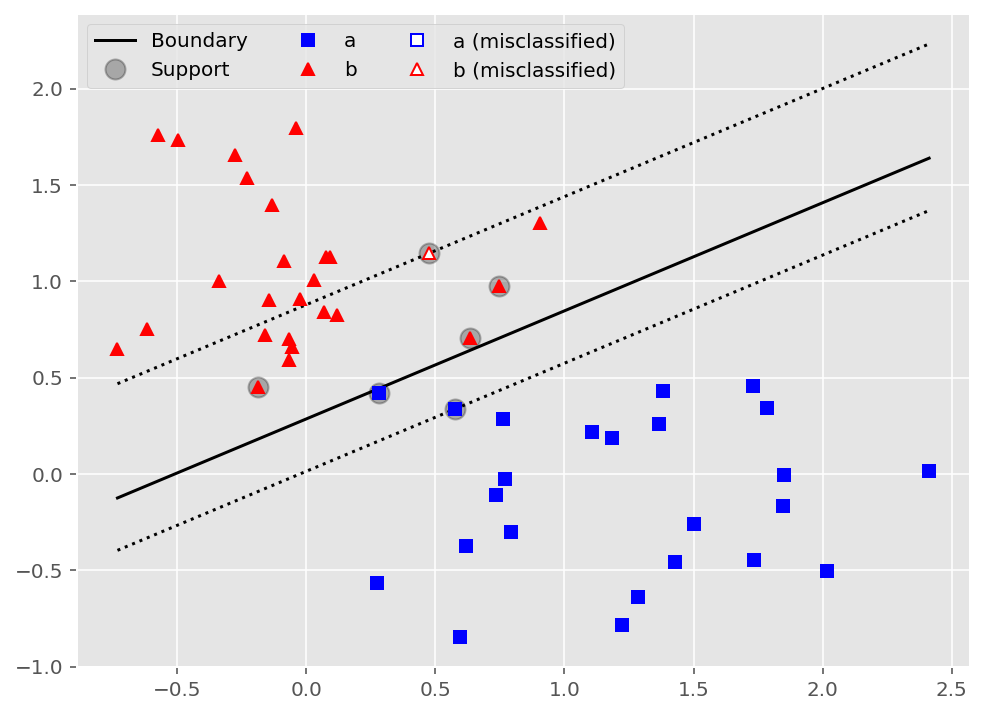

In [19]:
model = svm.SVC(kernel='linear', C=100) # will have the smallest margin hyperplane
model.fit(data[['x','y']], data['class'])
plot_linear_separator(model, data)

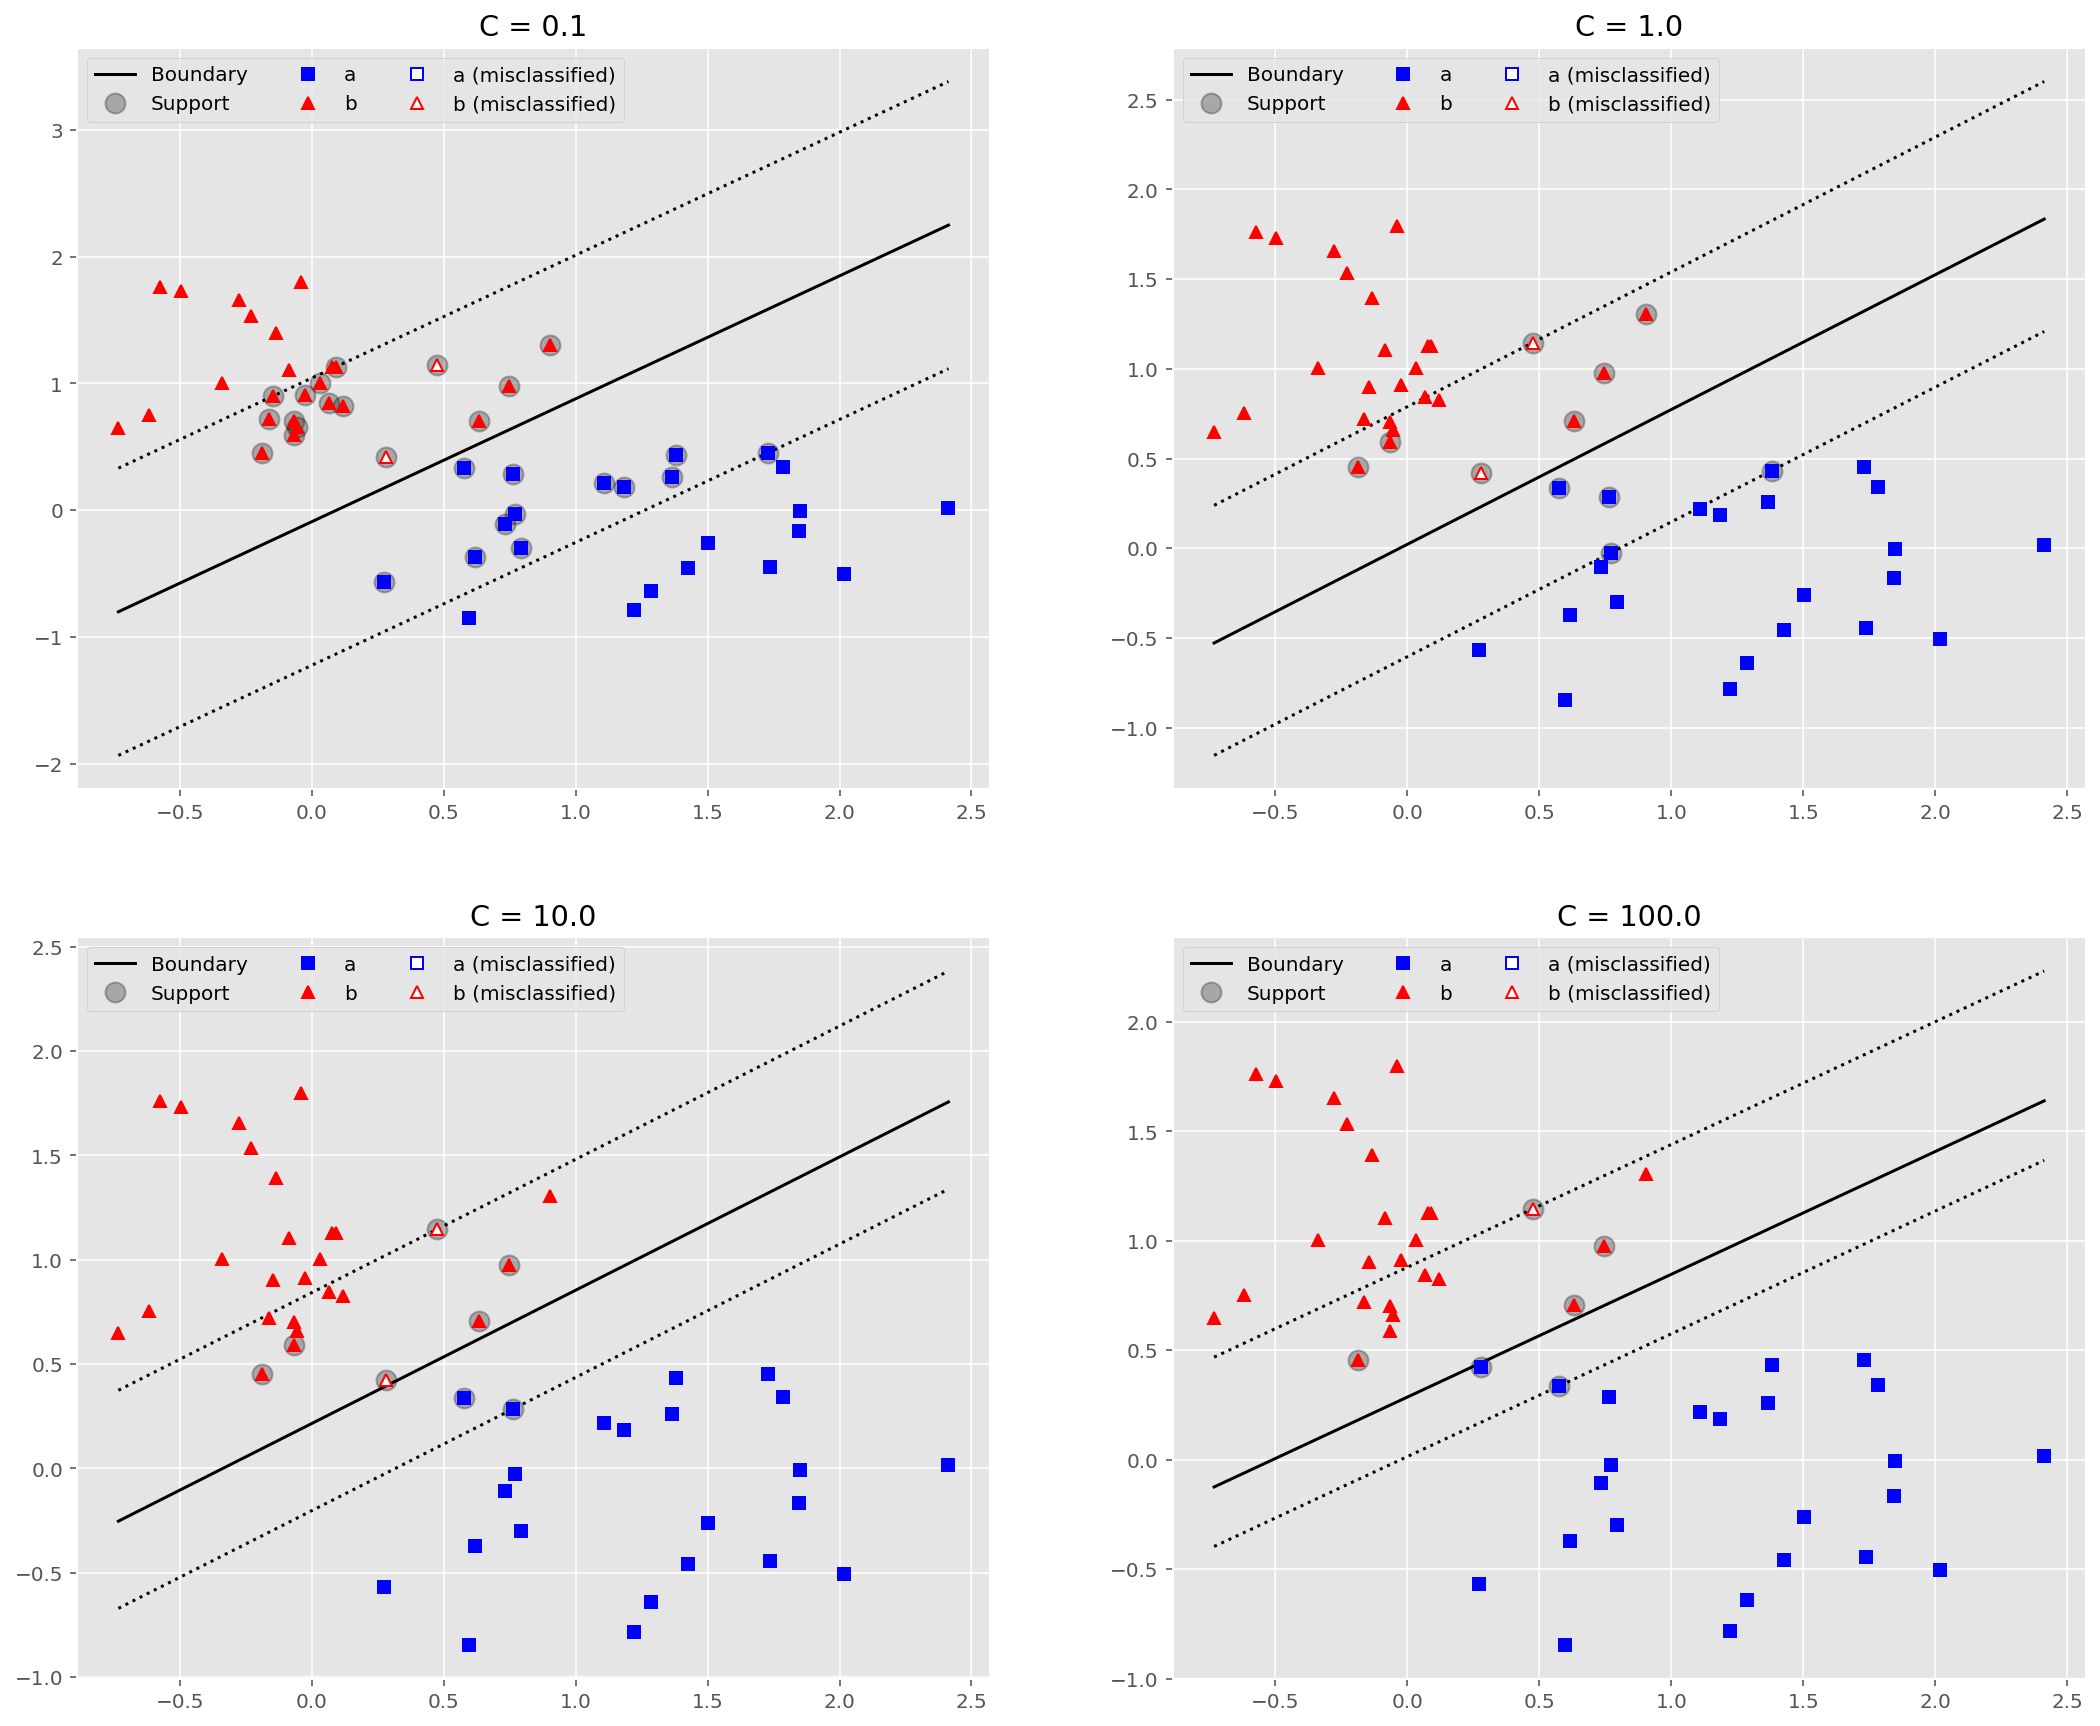

In [23]:
plt.figure(figsize=(18,15))

C_list = [0.1, 1, 10, 100]
for i_subplot, C in enumerate(C_list):
    model = svm.SVC(kernel='linear', C=C)
    model.fit(data[['x','y']], data['class'])
    ax = plt.subplot(2,2,i_subplot+1)
    plot_linear_separator(model, data, ax)
    plt.title('C = {:0.1f}'.format(C))
    
# as you can see in the below plots: a larger C value creates a smaller-margin hyperplane

## Non-Linear Data
---
It turns out that a quirk in the QP formulation for SVMs allows us to efficiently replace the linear separator model with a non-linear model.

This quirk is known as the "kernel trick".

It lets us use different *kernels* without significant added expense.

The most popular kernels are linear, polynomial, and radial basis function (RBF).  Radial basis functions are basically Gaussian surfaces centered on the data points.

Let's see how this works on our example problem from before:

In [22]:
def f(X):
    return 3 + 0.5 * X - X**2 + 0.15 * X**3

# convenience function for generating samples
def sample(n, fn, limits, sigma):
    width = limits[1] - limits[0]
    height = limits[3] - limits[2]
    x = np.random.random(n) * width + limits[0]
    y = np.random.random(n) * height + limits[2]
    s = y > fn(x)
    p = norm.cdf(np.abs(y - fn(x)), scale = sigma) # assigns p with normally distributed values according to its CDF
    r = np.random.random(n) # r is assigned n random variables from [0.0, 1.0).
    
    def assign(sign, prob, rnum):
        if sign:
            if rnum > prob:
                return 'b'
            else:
                return 'a'
        else:
            if rnum > prob:
                return 'a'
            else:
                return 'b'
        
    c = [assign(s[i], p[i], r[i]) for i in range(n)]
    
    return DataFrame({'x' : x, 'y' : y, 'class' : c})
    

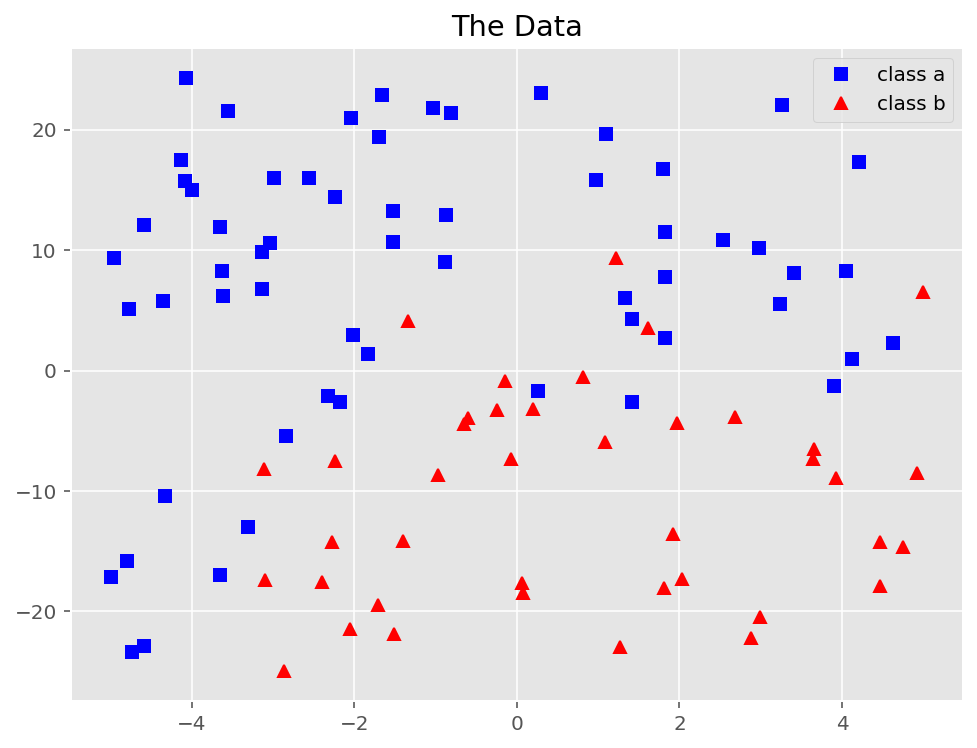

In [24]:
data = sample(100, f, [-5, 5, -25, 25], 5)
plt.figure(figsize=(8,6))
dataa = data[data['class']=='a']
datab = data[data['class']=='b']
plt.plot(dataa['x'], dataa['y'],'bs', label='class a')
plt.plot(datab['x'], datab['y'],'r^', label='class b')
plt.legend()
plt.title('The Data')
plt.show()

The "out of the box" default kernel for the Scikit-learn SVC is 'rbf':

In [25]:
model = svm.SVC()
model.fit(data[['x','y']], data['class'])


SVC()

As before, we can visualize the decision boundary by simply plotting all the points in our plane:

In [26]:
def plot_boundary(model, data):
    cmap = ListedColormap(['#8888FF','#FF8888'])
    xmin, xmax, ymin, ymax = -5, 5, -25, 25
    grid_size = 0.2
    xx, yy = np.meshgrid(np.arange(xmin, xmax, grid_size), 
                         np.arange(ymin, ymax, grid_size))
    pp = model.predict(np.c_[xx.ravel(), yy.ravel()])
    zz = np.array([{'a':0,'b':1}[ab] for ab in pp]) 
    zz = zz.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, zz, cmap = cmap)
    plot_predicted(model, data)
    plt.legend(loc='upper left', ncol=2)

<ipython-input-26-53d9b4961664>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


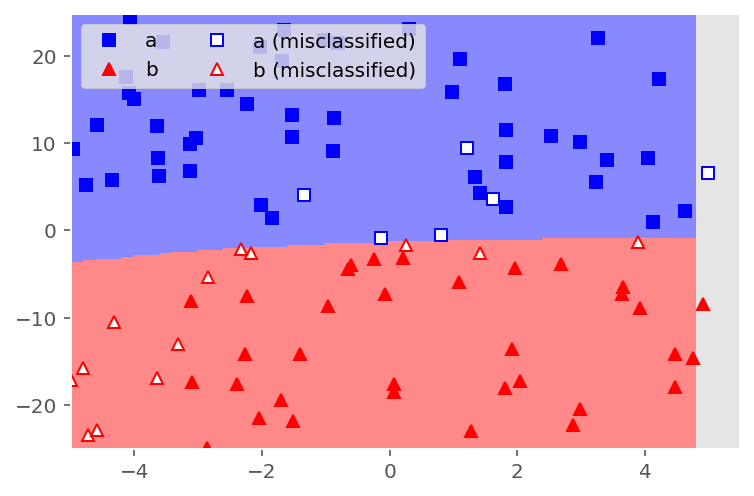

In [27]:
plot_boundary(model, data)


We can also plot the decision function in the plane:

In [28]:
def plot_decision(model, data):
    cmap = 'RdBu_r'
    xmin, xmax, ymin, ymax = -5, 5, -25, 25
    grid_size = 0.2
    xx, yy = np.meshgrid(np.arange(xmin, xmax, grid_size), 
                         np.arange(ymin, ymax, grid_size))
    pp = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    zz = pp.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, zz, cmap = cmap)
    plt.colorbar()
    plot_predicted(model, data)
    plt.legend(loc='upper left', ncol=2)

<ipython-input-28-276e3f029014>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


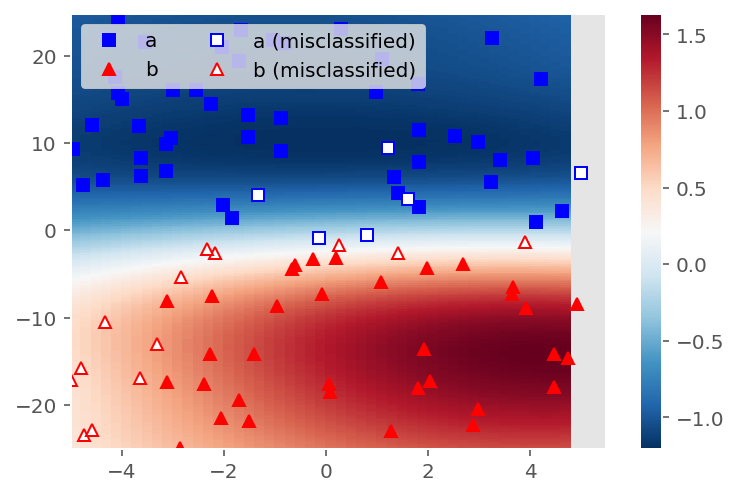

In [29]:
plot_decision(model, data)
plt.show()

## Effects of $\gamma$ and C

The RBF kernel has an additional parameter, called `gamma`.  A smaller gamma results in a shallower, more spread out Gaussian function, and therefore a smoother result:

<ipython-input-26-53d9b4961664>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


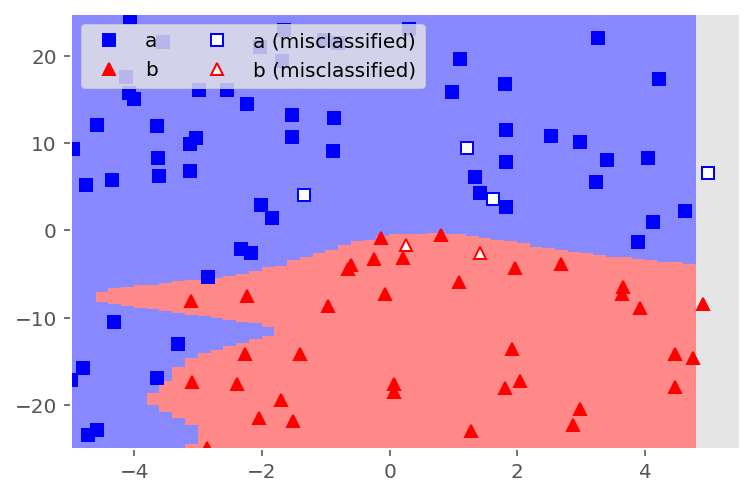

In [30]:
model = svm.SVC(gamma=0.1, C = 1)
model.fit(data[['x','y']], data['class'])
plot_boundary(model, data)


Conversely, a large gamma results in very narrow, spiky Gaussians.

<ipython-input-26-53d9b4961664>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


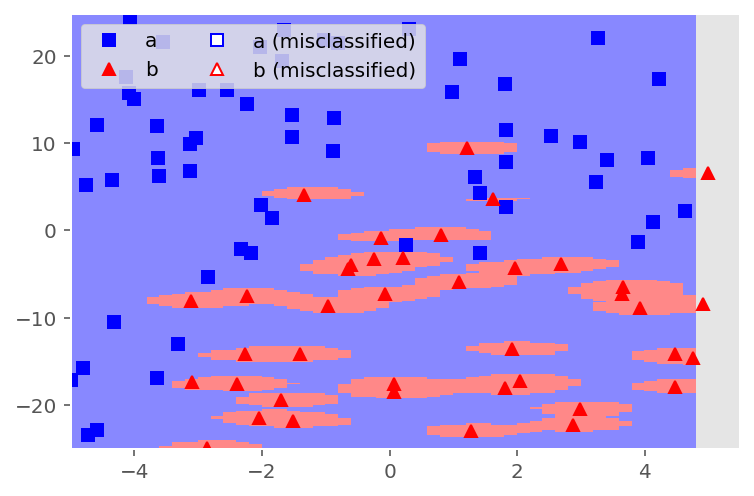

In [31]:
model = svm.SVC(gamma=2, C = 1)
model.fit(data[['x','y']], data['class'])
plot_boundary(model, data)

## Polynomial Kernel
---
There is also a polynomial kernel, which computes separators based on polynomial functions of the inputs.  It has an additional parameter, `coef0`, which generally needs to be set to 1.  The `degree` parameter determines the degree of the polynomial; typically degree is best kept at 2 or 3.

<ipython-input-26-53d9b4961664>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


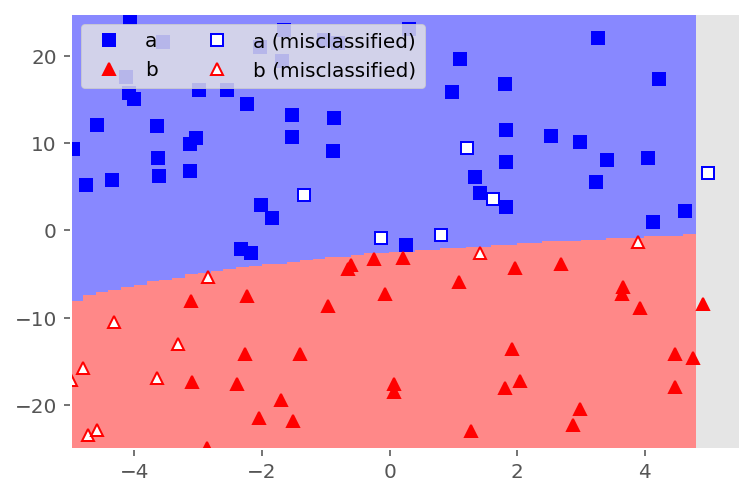

In [32]:
model = svm.SVC(kernel='poly', degree=3, coef0 = 1, C = 0.1)
model.fit(data[['x','y']], data['class'])
plot_boundary(model, data)
plt.show()

## Next Time
---
Model selection
- Cross validation
- Parameter search